# Assignment2

## Import Necessary Libraries

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import models
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

## Dataset Loading 

In [9]:
# Set device (use MPS for Apple Silicon, CUDA for other GPUs)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Define the CIFAR-10 data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for compatibility with pre-trained models
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


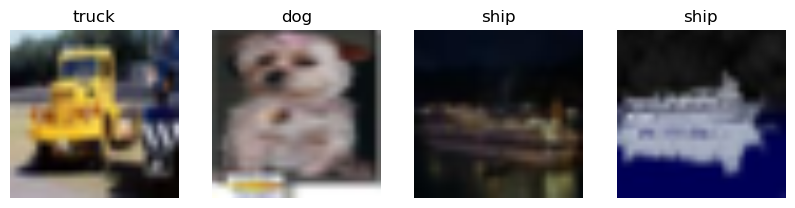

In [10]:
def show_cifar10_examples(dataset, classes, num_images=4):
    data_loader = DataLoader(dataset, batch_size=num_images, shuffle=True)
    images, labels = next(iter(data_loader))
    images = images / 2 + 0.5  # Unnormalize images
    np_images = images.numpy()

    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(np.transpose(np_images[i], (1, 2, 0)))
        plt.title(classes[labels[i]])
        plt.axis("off")
    plt.show()

# Define CIFAR-10 class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Show CIFAR-10 examples
show_cifar10_examples(train_dataset, classes)

In [11]:
# Helper function to get data loaders
def get_data_loaders(batch_size, subset_ratio=0.1):
    train_size = int(subset_ratio * len(train_dataset))
    val_size = int(train_size * 0.2)  # 20% of the training subset as validation set
    train_indices = np.random.choice(len(train_dataset), train_size, replace=False)
    val_indices = np.random.choice(train_indices, val_size, replace=False)
    train_subset = Subset(train_dataset, train_indices)
    val_subset = Subset(train_dataset, val_indices)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return train_loader, val_loader, test_loader

In [12]:
# Early stopping class
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Function to train and validate the model for one epoch
def train_validate_epoch(model, train_loader, val_loader, criterion, optimizer, device):
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()
    train_accuracy = 100 * train_correct / train_total

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    val_accuracy = 100 * val_correct / val_total
    return train_loss / len(train_loader), train_accuracy, val_loss / len(val_loader), val_accuracy

# Function to plot learning curves
def plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies, title):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{title} - Training and Validation Loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Training Accuracy")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{title} - Training and Validation Accuracy")
    plt.legend()
    plt.show()

# Function to evaluate model on test data and calculate accuracy, precision, recall, F1-score
def evaluate_metrics(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds) * 100
    precision = precision_score(all_labels, all_preds, average='weighted') * 100
    recall = recall_score(all_labels, all_preds, average='weighted') * 100
    f1 = f1_score(all_labels, all_preds, average='weighted') * 100
    
    # Print classification report for detailed metrics
    print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=test_dataset.classes))
    return accuracy, precision, recall, f1

# Function to evaluate model on test data
def evaluate_test_data(model, test_loader):
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
    return 100 * test_correct / test_total

def train_with_early_stopping(model_name, model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    early_stopping = EarlyStopping(patience=3, min_delta=0.001)
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(num_epochs):
        print(f"\n{model_name} - Epoch {epoch+1}/{num_epochs}")
        
        # Train and validate for one epoch
        train_loss, train_acc, val_loss, val_acc = train_validate_epoch(
            model, train_loader, val_loader, criterion, optimizer, device
        )
        
        # Append results to lists for plotting later
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        # Print training and validation metrics for this epoch
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")
        
        # Early stopping check
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    # Plot learning curve
    plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies, model_name)
    return model

In [13]:
# Define models
def get_resnet18_model():
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model.to(device)

def get_vgg16_model():
    model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 10)
    return model.to(device)

def get_mobilenet_v2_model():
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 10)
    return model.to(device)

In [14]:
# Grid search for ResNet18
batch_sizes = [16, 32, 64]
learning_rates = [0.01, 0.001, 0.0001]
num_epochs = 10
best_resnet_val_acc = 0
best_resnet_model = None
best_params = {'batch_size': None, 'learning_rate': None}

for batch_size in batch_sizes:
    for lr in learning_rates:
        print(f"\nTraining ResNet18 with batch size {batch_size} and learning rate {lr}")
        
        # Prepare data loaders
        train_loader, val_loader, test_loader = get_data_loaders(batch_size=batch_size)
        
        # Initialize model, criterion, and optimizer
        resnet18_model = get_resnet18_model()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(resnet18_model.fc.parameters(), lr=lr)
        
        # Train with early stopping and evaluate on validation set
        resnet18_model = train_with_early_stopping("ResNet18", resnet18_model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)
        val_acc = evaluate_metrics(resnet18_model, val_loader)[0]  # Only taking the accuracy from validation metrics
        print(f"ResNet18 Validation Accuracy: {val_acc:.2f}%")
        
        # Check if this configuration is the best so far based on validation accuracy
        if val_acc > best_resnet_val_acc:
            best_resnet_val_acc = val_acc
            best_resnet_model = resnet18_model
            best_params['batch_size'] = batch_size
            best_params['learning_rate'] = lr


Training ResNet18 with batch size 16 and learning rate 0.01

ResNet18 - Epoch 1/10


Training:   1%|▏         | 4/313 [00:09<07:54,  1.54s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x1466aa8e0>
Traceback (most recent call last):
  File "/Users/zhaozibo/anaconda3/envs/deep_Learning/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/Users/zhaozibo/anaconda3/envs/deep_Learning/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/zhaozibo/anaconda3/envs/deep_Learning/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zhaozibo/anaconda3/envs/deep_Learning/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zhaozibo/anaconda3/envs/deep_Learning/lib/python3.11

KeyboardInterrupt: 

In [ ]:
# Final evaluation of the best ResNet18 model on the test set
print(f"\nBest ResNet18 Model - Batch Size: {best_params['batch_size']}, Learning Rate: {best_params['learning_rate']}")
best_resnet_test_metrics = evaluate_metrics(best_resnet_model, test_loader)
print(f"Best ResNet18 Test Metrics - Accuracy: {best_resnet_test_metrics[0]:.2f}%, Precision: {best_resnet_test_metrics[1]:.2f}%, Recall: {best_resnet_test_metrics[2]:.2f}%, F1 Score: {best_resnet_test_metrics[3]:.2f}%")

# Evaluate VGG16 model

In [15]:
# Train and evaluate each model
batch_size = 32
num_epochs = 10
train_loader, val_loader, test_loader = get_data_loaders(batch_size=batch_size)

# Evaluate VGG16 model
print("\nTraining and Evaluating VGG16...")
vgg16_model = get_vgg16_model()
optimizer = optim.Adam(vgg16_model.classifier[-1].parameters(), lr=0.001)
vgg16_model = train_with_early_stopping("VGG16", vgg16_model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)
vgg16_test_metrics = evaluate_metrics(vgg16_model, test_loader)
print(f"VGG16 Test Metrics - Accuracy: {vgg16_test_metrics[0]:.2f}%, Precision: {vgg16_test_metrics[1]:.2f}%, Recall: {vgg16_test_metrics[2]:.2f}%, F1 Score: {vgg16_test_metrics[3]:.2f}%")


Training and Evaluating VGG16...

VGG16 - Epoch 1/10


Training:   1%|▏         | 2/157 [00:34<44:37, 17.28s/it]


KeyboardInterrupt: 

In [42]:
# Evaluate MobileNetV2 model
print("\nTraining and Evaluating MobileNetV2...")
mobilenet_v2_model = get_mobilenet_v2_model()
optimizer = optim.Adam(mobilenet_v2_model.classifier[-1].parameters(), lr=0.001)
mobilenet_v2_model = train_with_early_stopping("MobileNetV2", mobilenet_v2_model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)
mobilenet_v2_test_metrics = evaluate_metrics(mobilenet_v2_model, test_loader)
print(f"MobileNetV2 Test Metrics - Accuracy: {mobilenet_v2_test_metrics[0]:.2f}%, Precision: {mobilenet_v2_test_metrics[1]:.2f}%, Recall: {mobilenet_v2_test_metrics[2]:.2f}%, F1 Score: {mobilenet_v2_test_metrics[3]:.2f}%")

NameError: name 'best_resnet_model' is not defined

In [43]:
# Collect metrics for comparison
model_comparison = {
    "Model": ["Best ResNet18", "VGG16", "MobileNetV2"],
    "Accuracy (%)": [best_resnet_test_metrics[0], vgg16_test_metrics[0], mobilenet_v2_test_metrics[0]],
    "Precision (%)": [best_resnet_test_metrics[1], vgg16_test_metrics[1], mobilenet_v2_test_metrics[1]],
    "Recall (%)": [best_resnet_test_metrics[2], vgg16_test_metrics[2], mobilenet_v2_test_metrics[2]],
    "F1 Score (%)": [best_resnet_test_metrics[3], vgg16_test_metrics[3], mobilenet_v2_test_metrics[3]]
}

# Create a DataFrame for the comparison metrics and display as heatmap
df_comparison = pd.DataFrame(model_comparison)
print("\nModel Comparison Metrics:\n", df_comparison)

# Plot a heatmap for the comparison metrics
plt.figure(figsize=(8, 5))
sns.heatmap(df_comparison.set_index("Model"), annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
plt.title("Model Comparison Metrics (Accuracy, Precision, Recall, F1 Score)")
plt.show()